In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v0_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

In [4]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [5]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [6]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(data, classes)
m = SelectFromModel(clf, prefit=True)
data_new = m.transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [9]:
x_train, x_test, y_train, y_test = train_test_split(
									data_new, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 310)
(19517,)
(19517, 310)


In [17]:
learning_rate = 0.1
opt = 'ADAM'
lambda_l1 = 0.001
size_batch = 256
nb_epochs = 50

In [25]:
#9th try: feature selection + dropout + l2 regularizers 

model = Sequential()	
	
model.add(	
	Dense(512, input_dim = x_train.shape[1], activation = 'relu'))

model.add(Dropout(0.5))

model.add(	
	Dense(128, activation = 'relu'))

model.add(Dropout(0.3))

model.add(	
	Dense(32, activation = 'relu',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax',
	      kernel_regularizer = regularizers.l2(0.3)))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               159232    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 18)                594       
                                                                 
Total params: 229,618
Trainable params: 229,618
Non-trai

In [20]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [21]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [22]:
print(class_weights_d)

{0: 1.6610706838588876, 1: 0.40367233391246793, 2: 0.4585594793355419, 3: 1.467204179822583, 4: 1.585760715011172, 5: 0.7312519904831488, 6: 3.0139371477106014, 7: 2.150250647275932, 8: 1.5472906013398342, 9: 2.040967320261438, 10: 1.1041383797239195, 11: 0.30139371477106014, 12: 1.1937945377251735, 13: 1.09771084676172, 14: 1.255661712668082, 15: 2.73804012345679, 16: 1.4832611339109287, 17: 3.1337106615285806}


In [26]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
305/305 [==============================] - 5s 14ms/step - loss: 7.8175 - accuracy: 0.2398 - val_loss: 2.9884 - val_accuracy: 0.2563
Epoch 2/50
305/305 [==============================] - 4s 14ms/step - loss: 2.6447 - accuracy: 0.2831 - val_loss: 2.4272 - val_accuracy: 0.3454
Epoch 3/50
305/305 [==============================] - 4s 14ms/step - loss: 2.4073 - accuracy: 0.3297 - val_loss: 2.3351 - val_accuracy: 0.3521
Epoch 4/50
305/305 [==============================] - 4s 15ms/step - loss: 2.3232 - accuracy: 0.3586 - val_loss: 2.2617 - val_accuracy: 0.3726
Epoch 5/50
305/305 [==============================] - 4s 14ms/step - loss: 2.2662 - accuracy: 0.3831 - val_loss: 2.1957 - val_accuracy: 0.3908
Epoch 6/50
305/305 [==============================] - 4s 14ms/step - loss: 2.2252 - accuracy: 0.3989 - val_loss: 2.1193 - val_accuracy: 0.4227
Epoch 7/50
305/305 [==============================] - 4s 14ms/step - loss: 2.1955 - accuracy: 0.4060 - val_loss: 2.1112 - val_accuracy: 0.4130

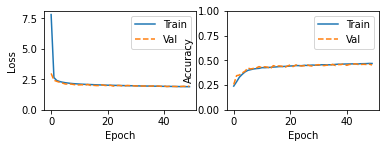

In [27]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

